<a href="https://colab.research.google.com/github/rowcrf/projeto-de-graduaca-01/blob/main/tensorflow_cavidade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import datetime,os
from google.colab import files 

Este notebook visa treinar uma rede neural capaz de predizer o comportamento de um fluido confinado em uma cavidade quadrada com tampa deslizante tendo como dados de entrada o número de Reynolds e o tempo 

## Pré processamento

Carregando os dados e indicando a quantidade de pontos na malha


In [ ]:
'''
banco de dados contendo dados da cavidade
Re
tempo
u [N+1xN+2]
v [N+2xN+1]
p [N+2xN+2]

'''
n = 25 #número de pontos da malha 
df = pd.read_csv('/content/drive/MyDrive/UnB/teste_ann/dados_cavidade.csv', low_memory =  True)
df.drop(df.columns[0], axis =1 ,inplace =True)

Separando os dados em entrada (x) e saída (y) e verificando o tamanho dos bancos de dados

In [ ]:
X = df[df.columns[0:2]]
y = df.drop(df.columns[0:2], axis =1)

In [ ]:
print(X.shape)
print(y.shape)

(75000, 2)
(75000, 2133)


Separando velocidade u, velocidade v e pressão em 3 diferentes bancos de dados e verificando o tamanho dos vetores

In [ ]:
y_u = y[y.columns[0:702]]
y_v = y[y.columns[702:1404]]
y_p = y[y.columns[1404:]]

In [ ]:
print(X.shape)
print(y_u.shape)
print(y_v.shape)
print(y_p.shape)


(75000, 2)
(75000, 702)
(75000, 702)
(75000, 729)


Teremos três conjuntos distintos para treinar os três modelos:
 - X_u e y_u, que são os conjuntos de entrada e saída para a velociada u
 - X_v e y_v, que são os conjuntos de entrada e saída para a velocidade v
 - X_p e y_p, que são os conjuntos de entrada e saída para a pressão p

 Esses conjuntos são separados em conjunto de treino (_train) e de teste (_test) com a função:

```
train_test_split()
```
Dividindo os conjuntos em $\frac{2}{3}$ para treino e $\frac{1}{3}$ para teste




In [ ]:
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X, y_u, test_size=0.33, random_state=101)
X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(X, y_v, test_size=0.33, random_state=101)
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, y_p, test_size=0.33, random_state=101)

Verificando as dimensões dos bancos de dados após a divisão

In [ ]:
print(X_train_u.shape)
print(X_test_u.shape)
print(y_train_u.shape)
print(y_test_u.shape)

(50250, 2)
(24750, 2)
(50250, 702)
(24750, 702)


In [ ]:
print(X_train_v.shape)
print(X_test_v.shape)
print(y_train_v.shape)
print(y_test_v.shape)

(50250, 2)
(24750, 2)
(50250, 702)
(24750, 702)


In [ ]:
print(X_train_p.shape)
print(X_test_p.shape)
print(y_train_p.shape)
print(y_test_p.shape)

(50250, 2)
(24750, 2)
(50250, 729)
(24750, 729)


## Definindo e treinando a rede

Neste primeiro momento, é proposta uma rede neural MLP (Multi Layer Perceptron)

Temos como dados de entrada do modelo:
- O número de neurônios da primeira camada;
- O número de neurônios da última camada;
- A quantidade de camadas

Seguindo a recomendação de se alterar linearmente o número de camadas entre a entrada e a saída, o modelo terá o número de neurônios definido pela função 

```
np.linspace(start,stop,num)
```
que gera um vetor linearmente espaçado iniciando no valor dado como $\textit{start}$, finalizando em $\textit{stop}$ contendo $\textit{num}$ pontos.


In [ ]:
def meu_modelo(n_input,n_output,layers):
 
  model = Sequential()
  neurons = np.linspace(n_input,n_output,layers).round(0)
  neurons = neurons.astype(int)
  model.add(keras.layers.Flatten(input_shape=[neurons[0]]))
  for i in range(1,layers-1):
    model.add(Dense(neurons[i],activation='relu'))

  model.add(Dense(neurons[layers-1]))
  opt = keras.optimizers.SGD(learning_rate=0.05)
  model.compile(optimizer=opt,loss='mse')

  return model

Será utilizado como critério de parada o valor mínimo da função MSE (Mean Squared Error) no dataset de validação (X_test,y_test). Após atingir o valor mínimo, ainda são realizados mais 30 passos e, caso não seja atingido um novo mínimo, o treinamento se encerra recuperando os pesos sinápticos utilizados quando se obteve o valor mínimo

In [ ]:
 my_callbacks = [EarlyStopping(monitor='val_loss', mode='min',
                            restore_best_weights=True ,verbose=1, patience=30)]
  

São definidos os números de camadas de cada uma das redes e também a quantidade de neurônios. Note que os valores de entrada e saída são definidos pelo banco de dados

In [ ]:
layers_u = 3
layers_v = 3
layers_p = 3

modelo_u = meu_modelo(2,702,layers_u)
modelo_v = meu_modelo(2,702,layers_v)
modelo_p = meu_modelo(2,729,layers_p)

Início do treino e, em seguida, visualização da curva de Epoch x Loss (MSE) para os dados de treino e teste. Ambos os dados são visualizados para evitar que ocorra um treinamento que termine em uma rede neural viciada. Este vício é evitado através do EarlyStopping, definido anteriormente

In [ ]:
modelo_u.fit(x=X_train_u, 
          y=y_train_u, 
          epochs=6000,
          validation_data=(X_test_u, y_test_u), verbose=1,
          callbacks=my_callbacks
          )
modelo_u.save('/content/drive/MyDrive/UnB/teste_ann/CavidadeVelU'+ str(layers_u)+ 'Camadas.h5')

Epoch 1/6000
1571/1571 [==============================] - 3s 2ms/step - loss: 1630.7994 - val_loss: 0.0670
Epoch 2/6000
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0604 - val_loss: 0.0436
Epoch 3/6000
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0394 - val_loss: 0.0286
Epoch 4/6000
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0259 - val_loss: 0.0190
Epoch 5/6000
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0173 - val_loss: 0.0129
Epoch 6/6000
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0118 - val_loss: 0.0090
Epoch 7/6000
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0083 - val_loss: 0.0065
Epoch 8/6000
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0060 - val_loss: 0.0049
Epoch 9/6000
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0046 - val_loss: 0.0039
Epoch 10/6000
1571/1571 [==============================] - 3s

(0.0, 0.01)

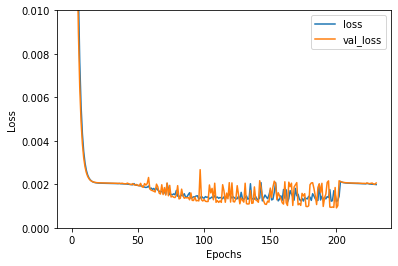

In [ ]:
model_loss_u = pd.DataFrame(modelo_u.history.history)
model_loss_u.to_csv('/content/drive/MyDrive/UnB/teste_ann/CavidadeVelU'+ str(layers_p)+ 'Camadas.csv')
model_loss_u = pd.read_csv('/content/drive/MyDrive/UnB/teste_ann/CavidadeVelU'+ str(layers_p)+ 'Camadas.csv')
model_loss_u.drop(model_loss_u.columns[0],axis=1,inplace=True)
model_loss_u.plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,0.01)

In [ ]:
modelo_v.fit(x=X_train_v, 
          y=y_train_v, 
          epochs=6000,
          validation_data=(X_test_v, y_test_v), verbose=1,
          callbacks=my_callbacks
          )
modelo_v.save('/content/drive/MyDrive/UnB/teste_ann/CavidadeVelV'+ str(layers_v)+ 'Camadas.h5')

Epoch 1/6000
1571/1571 [==============================] - 4s 2ms/step - loss: 3545.4125 - val_loss: 0.0209
Epoch 2/6000
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0189 - val_loss: 0.0138
Epoch 3/6000
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0125 - val_loss: 0.0092
Epoch 4/6000
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0084 - val_loss: 0.0063
Epoch 5/6000
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0058 - val_loss: 0.0044
Epoch 6/6000
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 7/6000
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 8/6000
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 9/6000
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 10/6000
1571/1571 [==============================] - 3s

(0.0, 0.01)

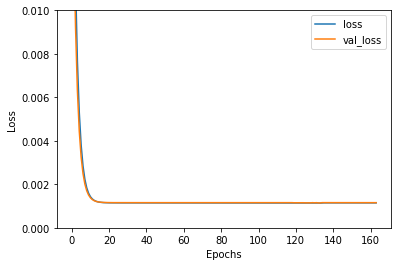

In [ ]:
model_loss_v = pd.DataFrame(modelo_v.history.history)
model_loss_v.to_csv('/content/drive/MyDrive/UnB/teste_ann/CavidadeVelV'+ str(layers_p)+ 'Camadas.csv')
model_loss_v = pd.read_csv('/content/drive/MyDrive/UnB/teste_ann/CavidadeVelV'+ str(layers_p)+ 'Camadas.csv')
model_loss_v.drop(model_loss_v.columns[0],axis=1,inplace=True)
model_loss_v.plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,0.01)

In [ ]:
modelo_p.fit(x=X_train_p, 
          y=y_train_p, 
          epochs=6000,
          validation_data=(X_test_p, y_test_p), verbose=1,
          callbacks=my_callbacks
          )
modelo_p.save('/content/drive/MyDrive/UnB/teste_ann/CavidadeP'+ str(layers_p)+ 'Camadas.h5')

Epoch 1/6000
1571/1571 [==============================] - 3s 2ms/step - loss: 1583.4166 - val_loss: 0.0112
Epoch 2/6000
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0104 - val_loss: 0.0090
Epoch 3/6000
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0085 - val_loss: 0.0075
Epoch 4/6000
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0069 - val_loss: 0.0064
Epoch 5/6000
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 6/6000
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0055 - val_loss: 0.0050
Epoch 7/6000
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 8/6000
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 9/6000
1571/1571 [==============================] - 3s 2ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 10/6000
1571/1571 [==============================] - 3s

(0.0, 0.01)

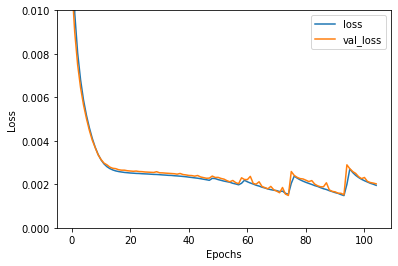

In [ ]:
model_loss_p = pd.DataFrame(modelo_p.history.history)
model_loss_p.to_csv('/content/drive/MyDrive/UnB/teste_ann/CavidadeP'+ str(layers_p)+ 'Camadas.csv')
model_loss_p = pd.read_csv('/content/drive/MyDrive/UnB/teste_ann/CavidadeP'+ str(layers_p)+ 'Camadas.csv')
model_loss_p.drop(model_loss_p.columns[0],axis=1,inplace=True)
model_loss_p.plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,0.01)

## Utilizando a rede

Inicialmente, carrega-se a rede treinada para que possa ser utilizada neste notebook. Esta etapa não é necessária caso você esteja treinando a rede neste momento e ela já esteja salva no ambiente de execução

In [ ]:
modelo_u = keras.models.load_model('/content/drive/MyDrive/UnB/teste_ann/CavidadeVelU'+ str(layers_u)+ 'Camadas.h5')
modelo_v = keras.models.load_model('/content/drive/MyDrive/UnB/teste_ann/CavidadeVelV'+ str(layers_u)+ 'Camadas.h5')
modelo_p = keras.models.load_model('/content/drive/MyDrive/UnB/teste_ann/CavidadeP'+ str(layers_u)+ 'Camadas.h5')


Escolhendo arbitrariamente um valor para ser utilizado como teste

In [ ]:
teste = X_test_u.iloc[0]

In [ ]:
teste

0    220.00
1      5.78
Name: 15578, dtype: float64

Definindo função que será utilizada para predizer os valores

In [ ]:
def predict_cavity(input,dataframe=False):
  if dataframe:
    dados = input.to_numpy()

  dados = dados.reshape((1,2))

  u_pred = modelo_u.predict(dados)
  v_pred = modelo_v.predict(dados)
  p_pred = modelo_p.predict(dados)

  u_pred = u_pred.reshape((n+1,n+2))
  v_pred = v_pred.reshape((n+2,n+1))
  p_pred = p_pred.reshape((n+2,n+2))
    
  return u_pred,v_pred,p_pred


In [ ]:
u_pred,v_pred,p_pred = predict_cavity(teste,True)

Definindo função que converterá valores obtidos para os valores que serão exibidos de maneira gráfica

In [ ]:
def plot_converter(u,v,p,n):
  uplot= np.zeros((n+1,n+1))
  vplot = np.zeros((n+1,n+1))
  for i in range (0,n+1):
    for j in range (0,n+1):
        uplot[i,j] = 0.5*(u[i,j] + u[i,j-1])
        vplot[i,j] = 0.5*(v[i,j] + v[i-1,j])

  pplot = np.zeros((n+1,n+1))
  for i in range (0,n):
    for j in range (0,n):
        pplot[i,j] = 0.25*(p[i,j]+p[i-1,j]+p[i,j-1]+p[i-1,j-1])
  return uplot, vplot, pplot

In [ ]:
uplot_pred,vplot_pred,pplot_pred = plot_converter(u_pred,v_pred,p_pred,25)

# Visualização gráfica

Definindo gráficos

In [ ]:
def plot_contour_and_stream(u,v,p,n,title):
  x = np.linspace(0,1,n+1)
  y = np.linspace(0,1,n+1)
  plt.contourf(x,y,np.transpose(p.round(3)))
  plt.streamplot(x,y,np.transpose(u),np.transpose(v), color = 'coral')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title(title)
  plt.grid(True, linestyle='--',lw=2)
  cbar = plt.colorbar()
  cbar.set_label('pressão',labelpad=30)
  plt.ylim(0,1)
  plt.xlim(0,1)
  plt.tight_layout()

In [ ]:
def plot_quiver(u,v,title): 
  x = np.linspace(0,1,n+1)
  y = np.linspace(0,1,n+1)
  plt.quiver(x,y,np.transpose(u),np.transpose(v))
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title(title)

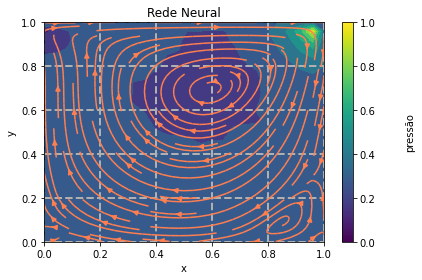

In [ ]:
plot_contour_and_stream(uplot_pred,vplot_pred,pplot_pred,25,'Rede Neural')
plt.savefig(fname= '/content/drive/MyDrive/UnB/teste_ann/figuras/Re_220_t_5p78_P_S_Rede_Neural.pdf',format='pdf')

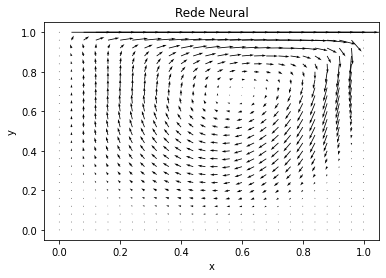

In [ ]:
plot_quiver(uplot_pred,vplot_pred,'Rede Neural')
plt.savefig(fname= '/content/drive/MyDrive/UnB/teste_ann/figuras/Re_220_t_5p78_Q_Rede_Neural.pdf',format='pdf')

Verificando no banco de dados o resultado numérico

In [ ]:
u_num = y_test_u.iloc[0]
v_num = y_test_v.iloc[0]
p_num = y_test_p.iloc[0]

In [ ]:
u_num = u_num.to_numpy()
v_num = v_num.to_numpy()
p_num = p_num.to_numpy()

In [ ]:
u_num = u_num.reshape((n+1,n+2))
v_num = v_num.reshape((n+2,n+1))
p_num = p_num.reshape((n+2,n+2))

In [ ]:
uplot_num,vplot_num,pplot_num = plot_converter(u_num,v_num,p_num,25)

Exibindo os gráficos

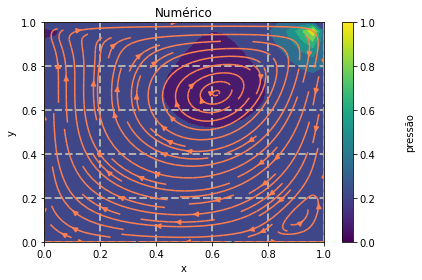

In [ ]:
plot_contour_and_stream(uplot_num,vplot_num,pplot_num,25,'Numérico')
plt.savefig(fname= '/content/drive/MyDrive/UnB/teste_ann/figuras/Re_220_t_5p78_P_S_Numerico.pdf',format='pdf')

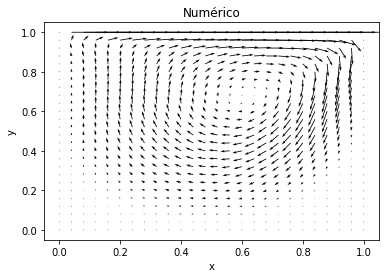

In [ ]:
plot_quiver(uplot_num,vplot_num,'Numérico')
plt.savefig(fname= '/content/drive/MyDrive/UnB/teste_ann/figuras/Re_220_t_5p78_Q_Numerico.pdf',format='pdf')

Comparativo da velocidade na linha central para o resultado numérico e rede neural

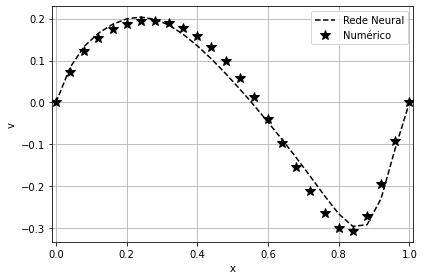

In [ ]:
x = np.linspace(0,1,n+1)
y = np.linspace(0,1,n+1)
plt.plot(x,((vplot_pred[:,y==0.48] + vplot_pred[:,y==0.52])*0.5).reshape(26),'--',ms=10, color='black',label = 'Rede Neural')
plt.plot(x,((vplot_num[:,y==0.48] + vplot_num[:,y==0.52])*0.5).reshape(26),'*',label='Numérico',color = 'black' , ms=10 )
plt.grid()
plt.ylabel('v')
plt.xlabel('x')
plt.legend()
plt.xlim(-0.01,1.01)
plt.tight_layout()
plt.savefig(fname= '/content/drive/MyDrive/UnB/teste_ann/figuras/Re_220_t_5p78_x_v.pdf',format='pdf')

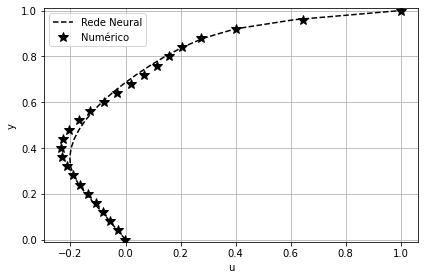

In [ ]:
plt.plot(((uplot_pred[x==0.48,:] + uplot_pred[x==0.52,:])*0.5).reshape(26),y,'--',ms=10, color='black',label = 'Rede Neural')
plt.plot(((uplot_num[x==0.48,:] + uplot_num[x==0.52,:])*0.5).reshape(26),y,'*',label='Numérico',color = 'black' , ms=10 )
plt.grid()
plt.ylabel('y')
plt.xlabel('u')
plt.legend()
plt.ylim(-0.01,1.01)
plt.tight_layout()
plt.savefig(fname= '/content/drive/MyDrive/UnB/teste_ann/figuras/Re_220_t_5p78_u_y.pdf',format='pdf')

Comparativo dos resultados obtidos para a pressão

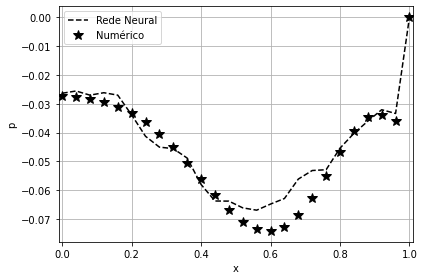

In [ ]:
plt.plot(x,((pplot_pred[:,y==0.48] + pplot_pred[:,y==0.52])*0.5).reshape(26),'--',ms=10, color='black',label = 'Rede Neural')
plt.plot(x,((pplot_num[:,y==0.48] + pplot_num[:,y==0.52])*0.5).reshape(26),'*',label='Numérico',color = 'black' , ms=10 )
plt.grid()
plt.ylabel('p')
plt.xlabel('x')
plt.legend()
plt.xlim(-0.01,1.01)
plt.tight_layout()
plt.savefig(fname= '/content/drive/MyDrive/UnB/teste_ann/figuras/Re_220_t_5p78_x_p.pdf',format='pdf')

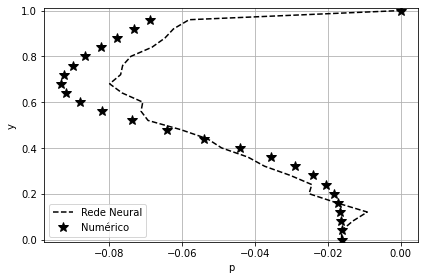

In [ ]:
plt.plot(((pplot_pred[x==0.48,:] + pplot_pred[x==0.52,:])*0.5).reshape(26),y,'--',ms=10, color='black',label = 'Rede Neural')
plt.plot(((pplot_num[x==0.48,:] + pplot_num[x==0.52,:])*0.5).reshape(26),y,'*',label='Numérico',color = 'black' , ms=10 )
plt.grid()
plt.ylabel('y')
plt.xlabel('p')
plt.legend()
plt.ylim(-0.01,1.01)
plt.tight_layout()
plt.savefig(fname= '/content/drive/MyDrive/UnB/teste_ann/figuras/Re_220_t_5p78_y_p.pdf',format='pdf')